## Outputting to multiple destinations

Like how in python the output of a function can be used multiple times, the output of a Deltaflow node
can also be used by multiple other nodes. However, this is only made possible by automatic modifications
made to the graph, that it may be important for graph creators to understand.

Let's start with defining a few nodes:

In [1]:
import deltalanguage as dl


@dl.DeltaBlock()
def foo() -> int:
    return 10

@dl.DeltaBlock()
def bar(a: int) -> int:
    return a*2

@dl.DeltaBlock()
def adder(a: int, b: int) -> int:
    return a + b

s = dl.lib.StateSaver(int, verbose=True) # helper node that saves the result

Now let's connect these nodes together in a graph:

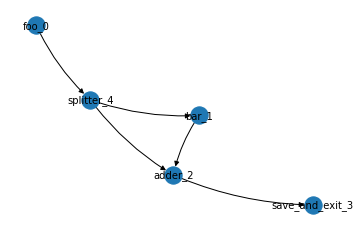

In [2]:
with dl.DeltaGraph() as graph:
    foo_out = foo()
    bar_out = bar(foo_out)
    s.save_and_exit(adder(foo_out, bar_out))

graph.draw(seed=32)

In the above visualisation, we can see that the graph does not look exactly how we might expect; instead there is an extra ``splitter`` node.
As the user has tried to send the same output to multiple destinations, a ``splitter`` node has been automatically inserted. This ensures
the number of outputs out of a given node is always the same, and thus helps us deploy nodes to target hardware.
So, in practise, an output from a node can only go to a maximum of one destination, but we let the user get around this by automatically 
creating and inserting ``splitter`` nodes when needed.

A more detailed representation of the same graph also confirms that the our node now just outputs a single channel to the splitter node, which then copies
the data received to the multiple target destinations specified during graph creation.

In [3]:
print(graph)

DeltaGraph[main] {
    node[foo_0]:
        ports:
            out:
                output, Int32 -> splitter_4.to_split
        bodies:
            *PyConstBody
                tags: foo

    node[bar_1]:
        ports:
            in:
                a, Int32
            out:
                output, Int32 -> adder_2.b
        bodies:
            *PyConstBody
                tags: bar

    node[adder_2]:
        ports:
            in:
                a, Int32
                b, Int32
            out:
                output, Int32 -> save_and_exit_3.val
        bodies:
            *PyConstBody
                tags: adder

    node[save_and_exit_3]:
        ports:
            in:
                val, Int32
        bodies:
            *PyFuncBody
                tags: save_and_exit

    node[splitter_4]:
        ports:
            in:
                to_split, Int32
            out:
                out0, Int32 -> bar_1.a
                out1, Int32 -> adder_2.a
        bodies:
          

This graph is correct and can be used by a runtime as normal.

In [4]:
rt = dl.DeltaPySimulator(graph)
rt.run()

# check the result: 
assert s.saved == [30]

saving 30


## Different values to multiple nodes

While the splitter has allowed us to send the same value to multiple destinations, sometimes we want to output different
values or even types to multiple nodes. For this we need to specify a list of multiple `outputs` in the node decorator.
Then when specifying the output from this block we put our multiple returns values in a tuple. 

Also note that if there is a particular output we do not want to send any value to, we can return the value `None` at 
the corresponding position in the output tuple.

In [6]:
@dl.DeltaBlock(outputs=[('out_1', int), ('out_2', int)])
def foo_multiple():
    return 10, 12

Note that the type of the output for this node is no longer inferred from the type annotation on the function definition, so it's up to the user what they put there. 

To refer to the different outputs of the `foo_multiple` node when creating our graph we specify an attribute of the node, where the name of the attribute is the string we assigned to a particular output in the above decorator.

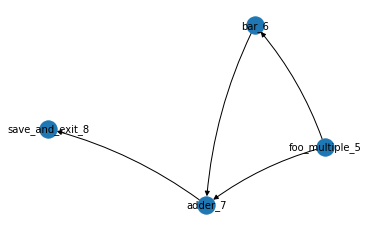

In [7]:
s = dl.lib.StateSaver(int, verbose=True)

with dl.DeltaGraph() as graph:
    foo = foo_multiple()
    bar_out = bar(foo.out_1)
    s.save_and_exit(adder(foo.out_2, bar_out))

graph.draw(seed=32)

We can see the shape of the graph is the same as before splitting in the previous example, with two wires coming out of
`foo_multiple`.

If we look at the string representation of the graph, we can see that the two different outputs of `foo_multiple` are indeed associated with the two different destinations we want to send data to.

In [8]:
print(graph)

DeltaGraph[main] {
    node[foo_multiple_5]:
        ports:
            out:
                out_1, Int32 -> bar_6.a
                out_2, Int32 -> adder_7.a
        bodies:
            *PyConstBody
                tags: foo_multiple

    node[bar_6]:
        ports:
            in:
                a, Int32
            out:
                output, Int32 -> adder_7.b
        bodies:
            *PyConstBody
                tags: bar

    node[adder_7]:
        ports:
            in:
                a, Int32
                b, Int32
            out:
                output, Int32 -> save_and_exit_8.val
        bodies:
            *PyConstBody
                tags: adder

    node[save_and_exit_8]:
        ports:
            in:
                val, Int32
        bodies:
            *PyFuncBody
                tags: save_and_exit

}



Finally, when running the graph we can see from the result that `bar` and `adder` received the correct different values from `foo_multiple`.

In [9]:
rt = dl.DeltaPySimulator(graph)
rt.run()

# check the result: 
assert s.saved == [32]

saving 32
